# COLLABORATIVE FILTERING RECOMMENDATION SYSTEM

In [1]:
print('>> Importing Libraries')

import pandas as pd
import numpy as np

from surprise import Reader, Dataset, SVD

from surprise.accuracy import rmse, mae
from surprise.model_selection import cross_validate

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.metrics.pairwise import cosine_similarity
import random
import nltk

nltk.download('punkt')
nltk.download('stopwords')

print('>> Libraries imported.')

>> Importing Libraries


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Harshaavardhini\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Harshaavardhini\AppData\Roaming\nltk_data...


>> Libraries imported.


[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
movies = pd.read_csv (r"movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
df = pd.read_csv (r"ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
df.drop('timestamp', axis=1, inplace=True)
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [5]:
movies['title'] = movies['title'].str.strip().str[:-7]
movies['genres'] = movies['genres'].str.replace('|', ' ')
movies['genres'] = movies['genres'].str.replace('(no genres listed)', '')
movies.head()

,movieId,title,genres
0,1,Toy Story,Adventure Animation Children Comedy Fantasy
1,2,Jumanji,Adventure Children Fantasy
2,3,Grumpier Old Men,Comedy Romance
3,4,Waiting to Exhale,Comedy Drama Romance
4,5,Father of the Bride Part II,Comedy


All frequencies:
             Frequency
Word                  
drama             4361
comedy            3756
thriller          1894
action            1828
romance           1596
adventure         1263
crime             1199
sci-fi             980
horror             978
fantasy            779
children           664
animation          611
mystery            573
documentary        440
war                382
musical            334
western            167
imax               158
film-noir           87


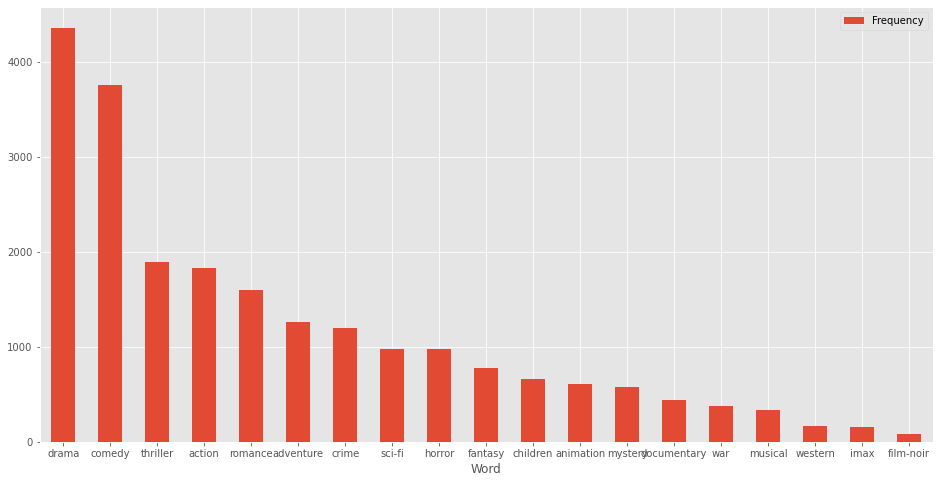

In [6]:
top_N = 25

txt = movies.genres.str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + [')', '(', ',', ':', "'s", '.', '!', '&', '?']
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

print('All frequencies:')
print('=' * 60)
rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word').head(25)
print(rslt)
print('=' * 60)

rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

matplotlib.style.use('ggplot')
rslt.plot.bar(rot=0, figsize=(16, 8), fontsize=10)

In [7]:
df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [8]:
n_movies = df["movieId"].nunique() 
n_users = df["userId"].nunique() 

print(f'Number of movies: {n_movies}')
print(f'Number of users: {n_users}')

Number of movies: 9724
Number of users: 610


In [9]:
available_ratings = df['rating'].count()
total_ratings = n_movies * n_users
missing_ratings = total_ratings - available_ratings
sparsity = (missing_ratings/total_ratings)*100
print(available_ratings)
print(total_ratings)
print( missing_ratings)
print(f'sparsity: {sparsity}%')

100836
5931640
5830804
sparsity: 98.30003169443864%


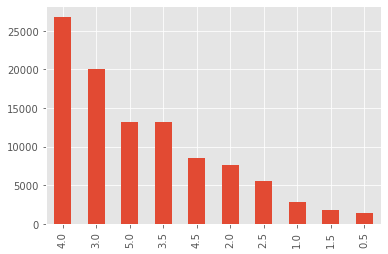

In [10]:
df['rating'].value_counts().plot(kind='bar')

In [11]:
cols = ['userId', 'movieId', 'rating']
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[cols], reader)

In [12]:
trainset = data.build_full_trainset()
antiset = trainset.build_anti_testset()

In [13]:
algo = SVD(n_epochs = 25, verbose = False)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose = True)
print('trained')

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8791  0.8679  0.8764  0.8758  0.8756  0.8749  0.0037  
MAE (testset)     0.6743  0.6677  0.6753  0.6724  0.6710  0.6721  0.0027  
Fit time          21.66   21.12   24.97   24.74   28.96   24.29   2.81    
Test time         0.47    0.57    0.66    0.43    1.58    0.74    0.43    
trained


In [14]:
predictions = algo.test(antiset)
predictions[0]

Prediction(uid=1, iid=318, r_ui=3.501556983616962, est=5, details={'was_impossible': False})

In [30]:
from collections import defaultdict
def get_top_n(predictions, n):
    # First map the predictions to each user.
      top_n = defaultdict(list)
      for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

   #Then sort the predictions for each user and retrieve the n highest ones.
      for uid, user_ratings in top_n.items():
          user_ratings.sort(key=lambda x: x[1], reverse=True)
          top_n[uid] = user_ratings[:n]

    return top_n
top_n = get_top_n(predictions, n=20)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, rating) in user_ratings])

1 [318, 48516, 58, 904, 908, 912, 3508, 750, 1246, 5902, 858, 1193, 1201, 1276, 7361, 1221, 3681, 3275, 46578, 177593]
2 [1204, 1258, 1225, 1248, 58, 2329, 1617, 3037, 1276, 57669, 750, 1283, 912, 908, 92259, 1246, 933, 1945, 1212, 1267]
3 [34405, 2858, 858, 1198, 6460, 109487, 55118, 40815, 3451, 7022, 1242, 56782, 951, 2019, 4019, 3030, 48516, 933, 6791, 912]
4 [1249, 91077, 1228, 16, 955, 5989, 750, 527, 1276, 79132, 4995, 1178, 151, 3451, 931, 3265, 60069, 112183, 1201, 2289]
5 [2571, 56782, 1204, 750, 930, 4011, 27773, 1225, 1276, 1193, 3037, 1242, 720, 933, 246, 2959, 858, 3147, 1617, 741]
6 [27831, 3578, 1207, 3451, 142488, 48516, 1270, 2542, 58, 1263, 1246, 1374, 171763, 97304, 158872, 56782, 92259, 2360, 2160, 1204]
7 [6016, 2467, 6711, 431, 68954, 115149, 2580, 1201, 69481, 1266, 3435, 5971, 7147, 2067, 1215, 16, 58998, 293, 1197, 6947]
8 [1204, 3468, 750, 3037, 1235, 2959, 2028, 1617, 1219, 1387, 44555, 1197, 48516, 1148, 1242, 2019, 1248, 1221, 2571, 2288]
9 [318, 2959, 497

# CONTENT BASED RECOMMENDATION SYSTEM

In [16]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(movies['genres'].values)
feature_names = vectorizer.get_feature_names()

In [17]:
genres_bow = pd.DataFrame(x.toarray(), columns=feature_names)
genres_bow['combined']= genres_bow.values.tolist()

In [18]:
movies['genres'] = genres_bow['combined']

In [19]:
movies.head()

,movieId,title,genres
0,1,Toy Story,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,Waiting to Exhale,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,Father of the Bride Part II,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [20]:
def get_cossim(movieid, top):
    # Creating dataframe with only IDs and genres
    movies_to_search = movies[['movieId', 'genres']]
    # Remove the ID of the movie we are measuring distance to
    movies_to_search = movies_to_search[movies_to_search.movieId != movieid]
    # Saving distances to new column
    movies_to_search['dist'] = movies_to_search['genres'].apply(lambda x: cosine_similarity(np.array(x).reshape(1, -1), np.array(movies.loc[movies['movieId'] == movieid]['genres'].values[0]).reshape(1, -1)))
    # Remove the genres column
    movies_to_search = movies_to_search.drop(columns=['genres'])
    # Distance value is in the list inside of the list so we need to unpack it
    movies_to_search = movies_to_search.explode('dist').explode('dist')
    # Sort the data and return top values
    return movies_to_search.sort_values(by=['dist'], ascending=False)['movieId'].head(top).values

In [21]:
def get_similar(userid):
    # Take all the movies watched by user
    movies_watched_by_user = df[df.userId == user_id]
    # Only 4.5 or higher rating filtered
    movies_watched_by_user = movies_watched_by_user[movies_watched_by_user['rating'] > 4.5]
    # Taking top 20 with highest ratings
    top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False).head(20))
    top_movies_user['watched_movieId'] = top_movies_user['movieId']
    top_movies_user = top_movies_user[['userId', 'watched_movieId']]
    # Find 5 similar movies for each of the selected above
    top_movies_user['similar'] = top_movies_user['watched_movieId'].apply(lambda x: (get_cossim(x, 5)))
    # Remove movies that user have already watched from recommendations
    result = [x for x in np.concatenate(top_movies_user['similar'].values, axis=0).tolist() if x not in top_movies_user.watched_movieId.values.tolist()]
    return result

In [22]:
def get_top(id, top):
    # taking movies that user may like
    smlr = get_similar(id)    
    # Calculating mean rationg for every movie
    movie_data = pd.merge(df, movies, on='movieId')
    ratings_mean_count = pd.DataFrame(movie_data.groupby('movieId')['rating'].mean())
    ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('movieId')['rating'].count())
    # Sorting movies with 10 or more ratings by users
    ratings_mean_count = ratings_mean_count[ratings_mean_count['rating_counts'] > 10]
    # Returning top N movies sorted by rating
    return ratings_mean_count[ratings_mean_count.index.isin(smlr)].sort_values(by=['rating'], ascending=False).head(top)

In [23]:
get_cossim(2, 10)

array([  2399, 130450, 119655, 104074,   2093, 158813,     60,   1009,
        41566,    126], dtype=int64)

In [50]:
top1 = get_top(610, 5)
top2 = get_top(254, 5)
top3 = get_top(317, 5)
content_rec1 = top1.index.values.tolist()
content_rec2 = top2.index.values.tolist()
content_rec3 = top3.index.values.tolist()

# HYBRID RECOMMENDATION SYSTEM

In [51]:
ans1=[]
ans2=[]
ans3=[]

u1=610
u2=254
u3=317

n=5
top_n = get_top_n(predictions, n)
top_n
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, rating) in user_ratings])

for i in range(0 ,n):
  p1=top_n[u1][i][0]
  p2=top_n[u2][i][0]
  p3=top_n[u3][i][0]
  ans1.append(p1)
  ans2.append(p2)
  ans3.append(p3)

rec_u1 = ans1 + content_rec1
rec_u2 = ans2 + content_rec2
rec_u3 = ans3 + content_rec3

In [52]:
rec_u1

[1704, 720, 2160, 1223, 951, 58559, 4973, 1262, 72226, 1148]

In [53]:
rec_u2

[1204, 1225, 1199, 933, 750, 58559, 4973, 1262, 72226, 1148]

In [54]:
rec_u3

[527, 1204, 912, 916, 1104, 58559, 4973, 1262, 72226, 1148]

In [55]:
movie_df = pd.read_csv(r"movies.csv")
recommended_movies = movie_df[movie_df["movieId"].isin(rec_u1)]
for row in recommended_movies.itertuples():   
    print(row.title, ": ", row.movieId)

Wallace & Gromit: The Best of Aardman Animation (1996) :  720
His Girl Friday (1940) :  951
Wallace & Gromit: The Wrong Trousers (1993) :  1148
Grand Day Out with Wallace and Gromit, A (1989) :  1223
Great Escape, The (1963) :  1262
Good Will Hunting (1997) :  1704
Rosemary's Baby (1968) :  2160
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) :  4973
Dark Knight, The (2008) :  58559
Fantastic Mr. Fox (2009) :  72226


In [56]:
recommended_movies = movie_df[movie_df["movieId"].isin(rec_u2)]
for row in recommended_movies.itertuples():  
    print(row.title, ": ", row.movieId)

Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) :  750
To Catch a Thief (1955) :  933
Wallace & Gromit: The Wrong Trousers (1993) :  1148
Brazil (1985) :  1199
Lawrence of Arabia (1962) :  1204
Amadeus (1984) :  1225
Great Escape, The (1963) :  1262
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) :  4973
Dark Knight, The (2008) :  58559
Fantastic Mr. Fox (2009) :  72226


In [57]:
recommended_movies = movie_df[movie_df["movieId"].isin(rec_u3)]
for row in recommended_movies.itertuples():
    print(row.title, ": ", row.movieId)

Schindler's List (1993) :  527
Casablanca (1942) :  912
Roman Holiday (1953) :  916
Streetcar Named Desire, A (1951) :  1104
Wallace & Gromit: The Wrong Trousers (1993) :  1148
Lawrence of Arabia (1962) :  1204
Great Escape, The (1963) :  1262
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) :  4973
Dark Knight, The (2008) :  58559
Fantastic Mr. Fox (2009) :  72226
